## Electivo 1: Astrofísica de la Formación Planetaria
### Nicolás Campos A
### Análisis de imagenes DSHARP 


In [2]:
#importar modulos relevantes para el proyecto 
import os, sys, time           
import numpy as np             
from astropy.io import fits
from astropy import wcs
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RectBivariateSpline
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata


%matplotlib inline

In [3]:
# parametros para plots
import matplotlib as mpl
mpl.rc('xtick.major', size=5, pad=3, width=2)
mpl.rc('ytick.major', size=5, pad=3, width=2)
mpl.rc('xtick.minor', size=2, pad=3, width=2)
mpl.rc('ytick.minor', size=2, pad=3, width=2)
mpl.rc('axes', linewidth=2, labelsize=14, titlesize=18)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', markersize=5)
mpl.rc('font', size=12)
cmap = 'inferno'

In [4]:
# nombre del disco a analizar
disk_name = 'IMLup'

# propiedades geometricas (de Huang et al. 2018 DSHARP II)
offRA, offDEC = -0.001, +0.001
incl, PA = 47.5, 144.5
inclr, PAr = np.radians(incl), np.radians(PA) #inclinación recta y PA en radianes 
rout = 1.2

In [5]:
# abrir imagen .FITS 
hdu = fits.open('IMLup_continuum.fits')
data = 1e3 * np.squeeze(hdu[0].data) #pasamos la imagen de Jy a mJy (no es necesario pero util)
header = hdu[0].header
w = wcs.WCS(header)
w_ra_dec = w.sub(2)
# verificar tamaño 4000x4000
print(data.shape)

# recortar la imagen para facilitar su analisis
cutout = Cutout2D(data, (2000, 2000), (1000, 1000), wcs=w_ra_dec)
image = cutout.data
print(image.shape)

# es OK que aparezca un warning en esta etapa ya que estamos cambiando propiedades de la imagen y el "header" se tiene que adaptar

(4000, 4000)
(1000, 1000)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
subhd = cutout.wcs.to_header()
ny, nx = image.shape
RAo = 3600 * subhd['CDELT1'] * (np.arange(nx) - (subhd['CRPIX1'] - 1))
DECo = 3600 * subhd['CDELT2'] * (np.arange(ny) - (subhd['CRPIX2'] - 1))
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC

# resolucion de la imagen ('beam')
freq = header['CRVAL3']
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

TypeError: __init__() takes 4 positional arguments but 5 were given

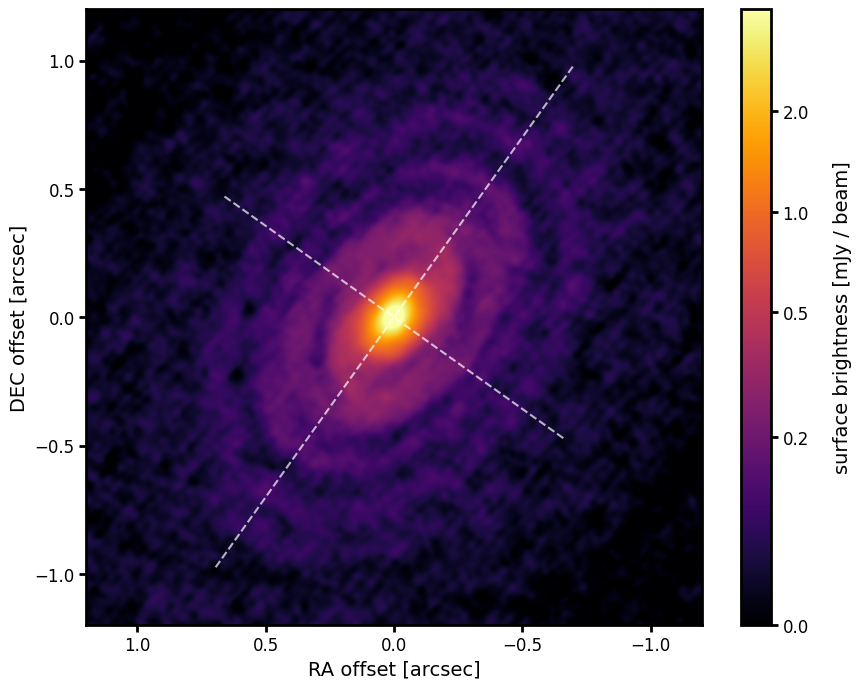

In [7]:
# image setups
im_bounds = (RAo_shift.max(), RAo_shift.min(), DECo_shift.min(), DECo_shift.max())
dRA_lims, dDEC_lims = [rout, -rout], [-rout, rout]

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch(10))

# image plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

# minor and major axes
rmaj = np.linspace(-rout, rout, 2)
ax.plot(rmaj * np.sin(PAr), rmaj * np.cos(PAr), '--w', alpha=0.7)
ax.plot(rmaj * np.cos(inclr) * np.sin(PAr - 0.5*np.pi), 
        rmaj * np.cos(inclr) * np.cos(PAr - 0.5*np.pi), '--w', alpha=0.7)

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

## Ahora continua con los siguientes pasos para completar el trabajo (deproyeccion, conversión a coordenadas polares, perfil radial, etc). 

### Rotación de la imagen

##### Matriz de rotación

In [14]:
#definimos la matriz de rotación
#Pregunta (3?)
# en primer lugar definimos la matriz de rotación
R_PAr = np.array([[np.cos(PAr), -np.sin(PAr)], [np.sin(PAr), np.cos(PAr)]]) #R_PAr rotación aplicada a PA
print(R_PAr) #printeamos R_PAr para ver si la matriz está funcionando
x_prime = R_PAr[0,0] * offRA + R_PAr[0,1] * offDEC
y_prime = R_PAr[1,0] * offRA + R_PAr[1,1] * offDEC
print(x_prime) #repetimos para saber si x_prima e y_prima tienen sentido
print(y_prime)

[[-0.81411552 -0.58070296]
 [ 0.58070296 -0.81411552]]
0.0002334125626453793
-0.001394818474067259



### Metodo RectBivariateSpline

##### Rotación de la imagen

(1000, 1000)


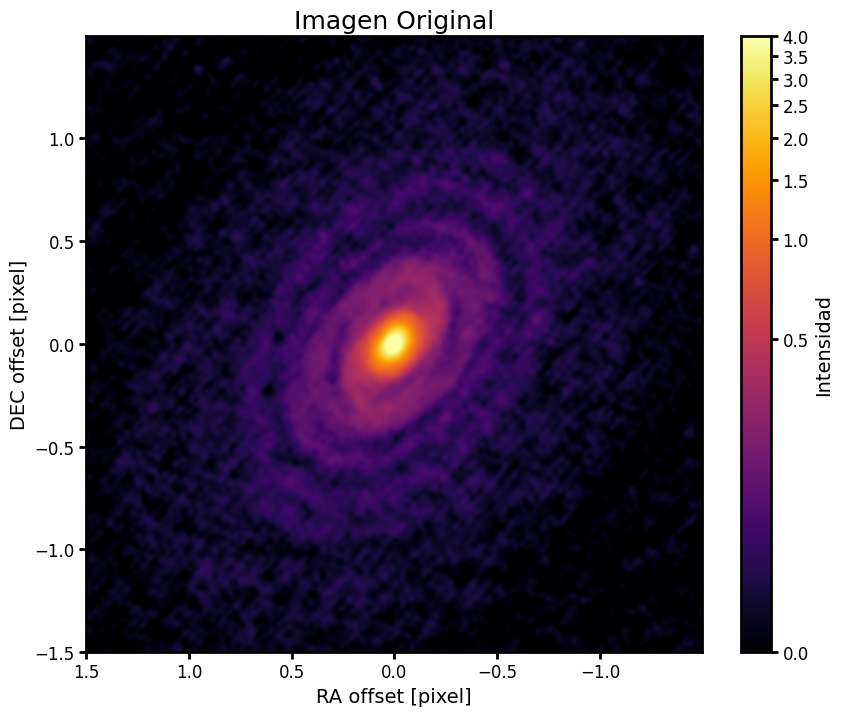

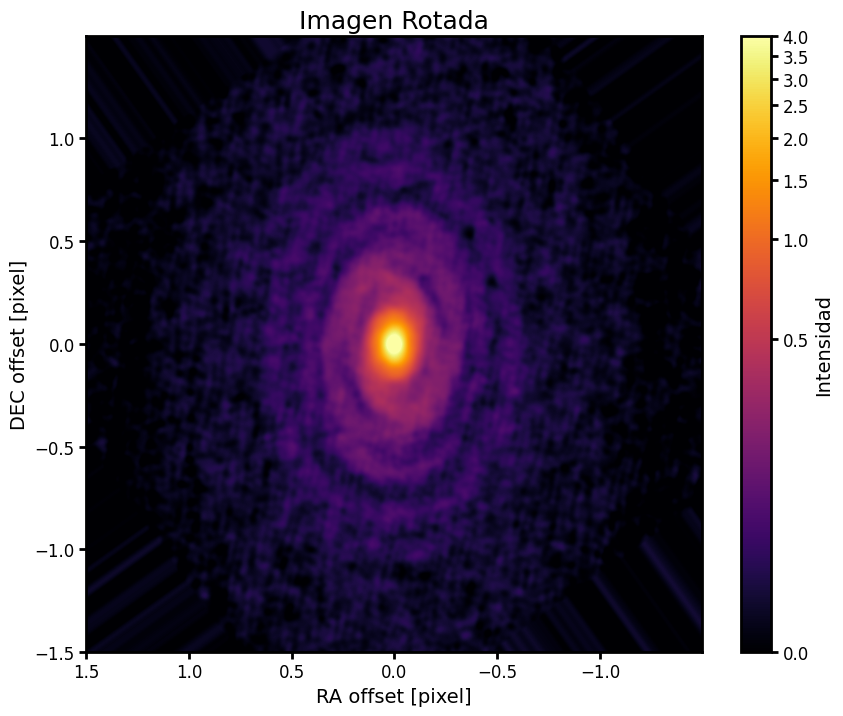

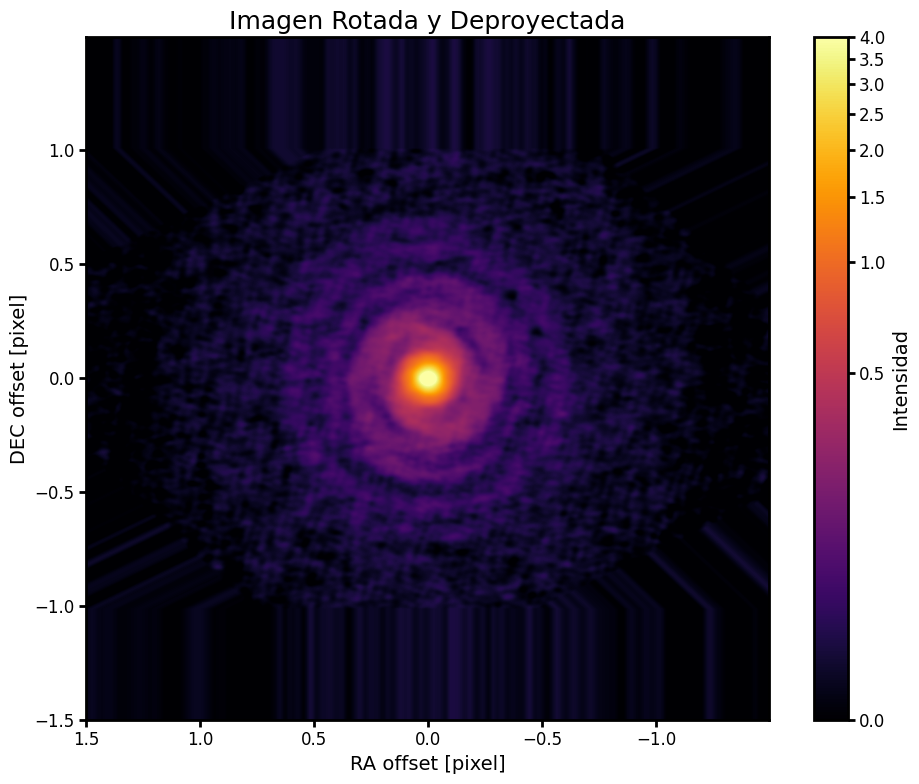

In [15]:


#funcion para rotar la imagen(misma funcion anterior, solo que las separé para cachar en que fallaba el codigo)
def rotate_image(image, PAr):
    # Dimensiones de la imagen original
    ny, nx = image.shape
    
    # Matriz de rotación
    R_PAr = np.array([[np.cos(PAr), -np.sin(PAr)], [np.sin(PAr), np.cos(PAr)]])
    
    # Coordenadas centradas en el centro de la imagen original
    y, x = np.indices((ny, nx))
    x_centered = x - (nx - 1) / 2
    y_centered = y - (ny - 1) / 2
    
    # Aplicar la rotación a las coordenadas centradas
    x_prime = R_PAr[0, 0] * x_centered + R_PAr[0, 1] * y_centered + (nx - 1) / 2
    y_prime = R_PAr[1, 0] * x_centered + R_PAr[1, 1] * y_centered + (ny - 1) / 2
    
    # Interpolación de la imagen rotada y deproyectada
    interpolator = RectBivariateSpline(np.arange(ny), np.arange(nx), image, kx=1, ky=1)
    rotated_image = interpolator(y_prime, x_prime, grid=False)
    
    return rotated_image

# Función para deproyectar la imagen
def deproject_image(image, incl):
    # Dimensiones de la imagen original
    ny, nx = image.shape
    
    # Convertir ángulo de inclinación a radianes
    incl_rad = np.radians(incl)
    
    # Coordenadas centradas en el centro de la imagen original
    y, x = np.indices((ny, nx))
    x_centered = x - (nx - 1) / 2
    y_centered = y - (ny - 1) / 2
    
    # Aplicar la deproyección (escalar en el eje y por el coseno de la inclinación)
    y_deprojected = y_centered / np.cos(incl_rad)
    
    # Interpolación de la imagen deproyectada
    interpolator = RectBivariateSpline(np.arange(ny), np.arange(nx), image, kx=1, ky=1) #volvi a ocupar rectbivariatespline porque inter2pd me daba errores de indices, el manejo de este metodo lo encontré en astronomy stack exchange
    deprojected_image = interpolator(y_deprojected.ravel() + (ny - 1) / 2, x_centered.ravel() + (nx - 1) / 2, grid=False)
    
    return deprojected_image.reshape(ny, nx)

# Rotar la imagen
rotated_image = rotate_image(image, PAr)

# Deproyectar la imagen rotada
deprojected_image = deproject_image(rotated_image, incl)

print(deprojected_image.shape)
# Visualización de la imagen original, rotada y deproyectada


plt.figure(figsize=(10, 8))
plt.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
plt.colorbar(label='Intensidad')
plt.xlabel('RA offset [pixel]')
plt.ylabel('DEC offset [pixel]')
plt.title('Imagen Original')

plt.figure(figsize=(10, 8))
plt.imshow(rotated_image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
plt.colorbar(label='Intensidad')
plt.xlabel('RA offset [pixel]')
plt.ylabel('DEC offset [pixel]')
plt.title('Imagen Rotada')

plt.figure(figsize=(10, 8))
plt.imshow(deprojected_image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
plt.colorbar(label='Intensidad')
plt.xlabel('RA offset [pixel]')
plt.ylabel('DEC offset [pixel]')
plt.title('Imagen Rotada y Deproyectada')

plt.tight_layout()
plt.show()


/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/2874439062.py:4: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(RAo_shift, DECo_shift, image, fill_value=0)
/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/2874439062.py:21: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grid

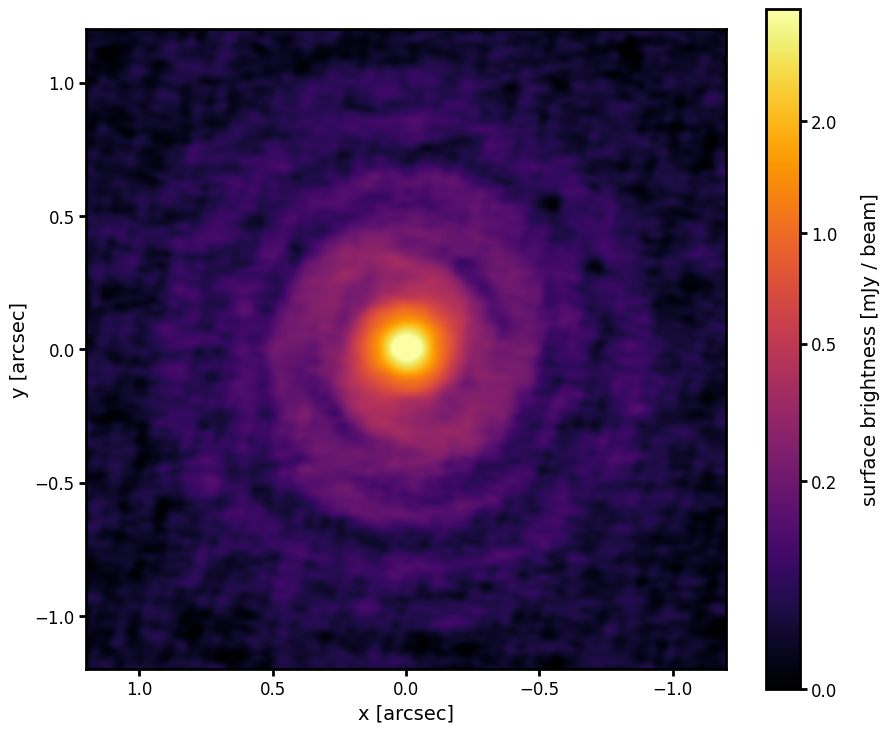

In [16]:
## 2. Imagen derotada

# función para (linealmente) interpolar el mapa
f = interp2d(RAo_shift, DECo_shift, image, fill_value=0)

# coordenadas de la matriz de la imagen deproyectada de -1.5 a 1.5 arcsec con el mismo tamaño de paso de la imagen del cielo
disk_delt = 3600 * subhd['CDELT2']
nxd = nyd = 1001
i0 = nxd // 2
j0 = nyd // 2
xdisk = (np.arange(nxd)-i0)*(-disk_delt)
ydisk = (np.arange(nyd)-j0)*disk_delt
image_deproj = np.zeros((nyd, nxd))

# cálculo pixel por pixel mediante bucles es lento...
for j in range(nyd):
    for i in range(nxd):
        # aplicar la transformación inversa para llegar a las coordenadas del cielo
        dra  = np.cos(PAr)*xdisk[i]*np.cos(inclr) + np.sin(PAr)*ydisk[j]
        ddec = -np.sin(PAr)*xdisk[i]*np.cos(inclr) + np.cos(PAr)*ydisk[j]
        image_deproj[j,i] = f(dra, ddec)

# plot de la imagen deproyectada - los anillos deberían verse como círculos

deproj_bounds = (xdisk.max(), xdisk.min(), ydisk.min(), ydisk.max())
xdisk_lims, ydisk_lims = [rout, -rout], [-rout, rout]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image_deproj, origin='lower', cmap=cmap, extent=deproj_bounds, norm=norm, aspect='equal')

ax.set_xlim(xdisk_lims)
ax.set_ylim(ydisk_lims)
ax.set_xlabel('x [arcsec]')
ax.set_ylabel('y [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

fig.savefig('IMLup_deprojected.pdf')

## 4 y 5. Mapa en coordenadas polares y perfil radial

disk_delt: 0.00299999999999988
i0: 500
xdisk: [ 1.5    1.497  1.494  1.491  1.488  1.485  1.482  1.479  1.476  1.473
  1.47   1.467  1.464  1.461  1.458  1.455  1.452  1.449  1.446  1.443
  1.44   1.437  1.434  1.431  1.428  1.425  1.422  1.419  1.416  1.413
  1.41   1.407  1.404  1.401  1.398  1.395  1.392  1.389  1.386  1.383
  1.38   1.377  1.374  1.371  1.368  1.365  1.362  1.359  1.356  1.353
  1.35   1.347  1.344  1.341  1.338  1.335  1.332  1.329  1.326  1.323
  1.32   1.317  1.314  1.311  1.308  1.305  1.302  1.299  1.296  1.293
  1.29   1.287  1.284  1.281  1.278  1.275  1.272  1.269  1.266  1.263
  1.26   1.257  1.254  1.251  1.248  1.245  1.242  1.239  1.236  1.233
  1.23   1.227  1.224  1.221  1.218  1.215  1.212  1.209  1.206  1.203
  1.2    1.197  1.194  1.191  1.188  1.185  1.182  1.179  1.176  1.173
  1.17   1.167  1.164  1.161  1.158  1.155  1.152  1.149  1.146  1.143
  1.14   1.137  1.134  1.131  1.128  1.125  1.122  1.119  1.116  1.113
  1.11   1.107  1.104  1.101  1

/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/3706222461.py:36: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(xdisk, ydisk, deprojected_image, kind='linear', fill_value=0)
/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/3706222461.py:52: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new cod

r.min(): 0.00299999999999988
r.max(): 1.2029999999999519
theta.min(): -180.0
theta.max(): 180.0


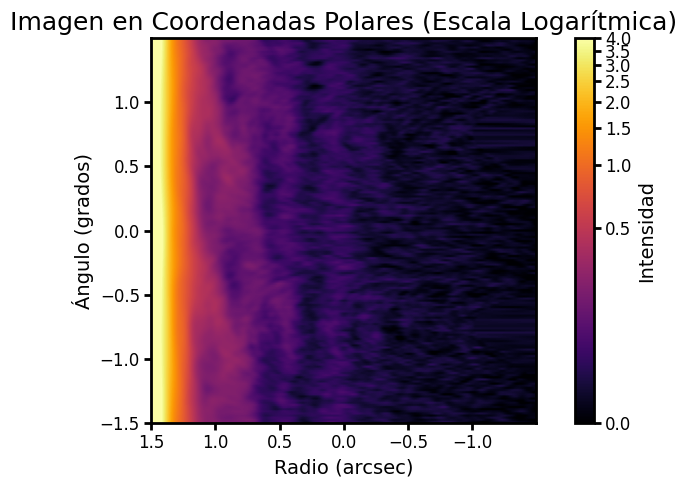

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp2d

# Coordenadas de la matriz de la imagen deproyectada de -0.2 a 0.2 arcsec con el mismo tamaño de paso de la imagen del cielo
disk_delt = 3600 * subhd['CDELT2']
nxd = nyd = 1000
i0 = nxd // 2
j0 = nyd // 2

# Coordenadas del disco
xdisk = (np.arange(nxd) - i0) * (-disk_delt)
ydisk = (np.arange(nyd) - j0) * disk_delt

# Imprimir para verificar los valores
print("disk_delt:", disk_delt)
print("i0:", i0)
print("xdisk:", xdisk)
print("ydisk:", ydisk)

# Definir el radio que encierra el disco basado en observaciones visuales o análisis previo
# Aquí se establece el radio de 1.2 en RA offset (arcsec)
rout_ra_offset = 1.2

# Convertir la escala de placa a arcsec por píxel
arcsec_per_pixel1 = subhd['CDELT1'] * 3600  # arcsec por píxel
arcsec_per_pixel2 = subhd['CDELT2'] * 3600  # arcsec por píxel

print(f"arcsec_per_pixel1: {arcsec_per_pixel1}")
print(f"arcsec_per_pixel2: {arcsec_per_pixel2}")

arcsec_per_pixel = arcsec_per_pixel2

# Interpolación de la imagen deproyectada
f = interp2d(xdisk, ydisk, deprojected_image, kind='linear', fill_value=0)

# Definir dr como arcseconds por píxel
dr = arcsec_per_pixel
r = np.arange(dr, rout_ra_offset + dr, dr)  # Asegurar que se cubra hasta 1.2 arcsec
theta = np.linspace(-180, 180, 181)  # Más puntos en theta para mayor resolución
image_polar = np.zeros((theta.size, r.size))

# Convertir a coordenadas polares
theta_rad = np.deg2rad(theta)  # Convertir todos los ángulos a radianes de una vez

for j in range(theta.size):
    for i in range(r.size):
        # Aplicar la transformación inversa para obtener las coordenadas del disco
        xd = r[i] * np.cos(theta_rad[j])  # Coordenada x en el disco
        yd = r[i] * np.sin(theta_rad[j])  # Coordenada y en el disco
        image_polar[j, i] = f(xd, yd)

# Asegurar que todos los valores sean positivos antes de aplicar LogNorm
image_polar[image_polar <= 0] = np.min(image_polar[image_polar > 0]) / 10  # O cualquier valor pequeño adecuado

# Imprimir los valores mínimos y máximos de r y theta
print("r.min():", r.min())
print("r.max():", r.max())
print("theta.min():", theta.min())
print("theta.max():", theta.max())

# Definir los límites de la extensión correctamente
extent = (r.min(), r.max(), theta.min(), theta.max())

# Graficar la imagen en coordenadas polares en escala logarítmica
plt.figure(figsize=(10, 5))
plt.imshow(image_polar, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
plt.xlabel('Radio (arcsec)')
plt.ylabel('Ángulo (grados)')
plt.title('Imagen en Coordenadas Polares (Escala Logarítmica)')
plt.colorbar(label='Intensidad')
plt.show()


/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/1481415390.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(xdisk, ydisk, deprojected_image, kind='cubic', fill_value=0)
/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/1481415390.py:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code,

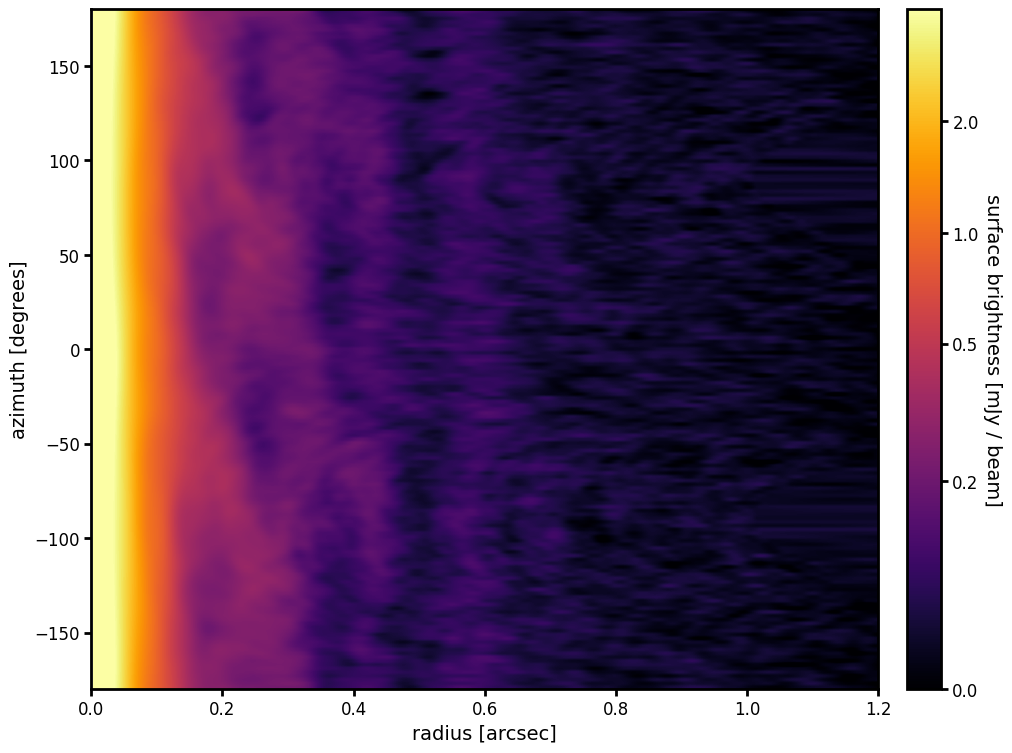

In [18]:
# 4 y 5. Mapa en coordenadas polares y perfil radial

f = interp2d(xdisk, ydisk, deprojected_image, kind='cubic', fill_value=0)

# coordenadas polares
dr = disk_delt
r = np.arange(dr, 2*rout, dr)
theta = np.linspace(-180, 180, 181)
image_polar = np.zeros((theta.size, r.size))

for j in range(theta.size):
    for i in range(r.size):
        # aplicar la transformación inversa para llegar a las coordenadas del disco
        xd = r[i] * np.cos(np.radians(theta[j]))
        yd = r[i] * np.sin(np.radians(theta[j]))
        image_polar[j,i] = f(xd, yd)

# image setups
polar_bounds = (r.min(), r.max(), theta.min(), theta.max())
r_lims = [0, rout]
theta_lims = [theta.min(), theta.max()]

# set up and plot the images on the specified scale
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(image_polar, origin='lower', cmap=cmap, extent=polar_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(theta_lims)
#ax.grid()
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.03)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

fig.savefig('IMLup_polar.pdf')

/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/4186647367.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(xdisk, ydisk, deprojected_image, kind='cubic', fill_value=0)
/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_1017/4186647367.py:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code,

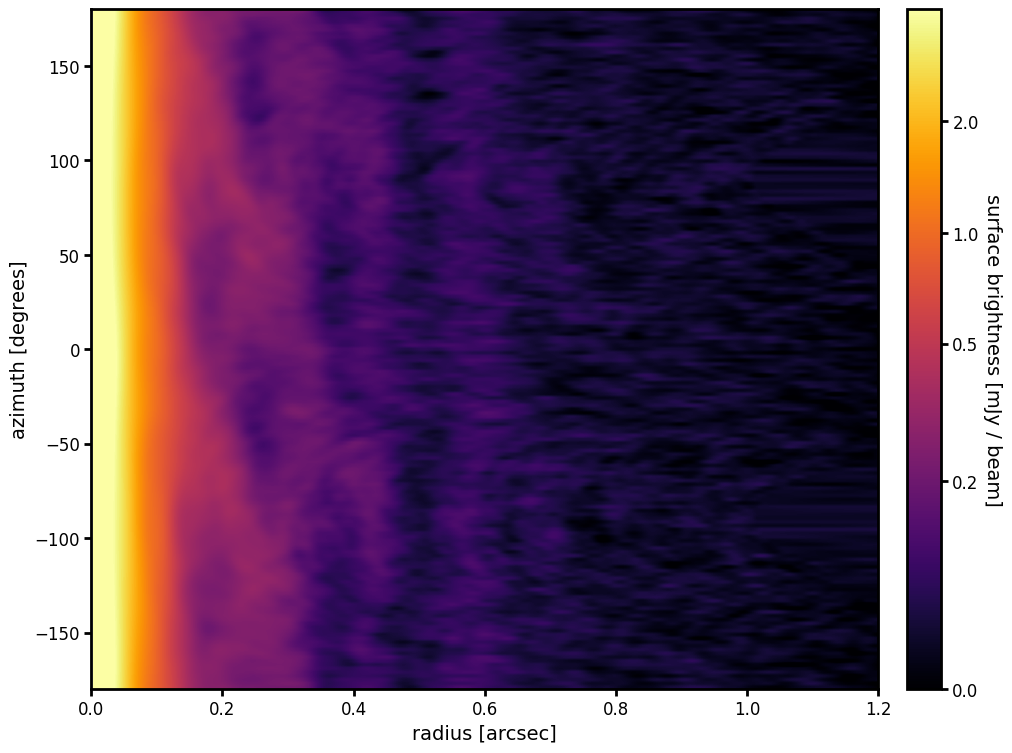

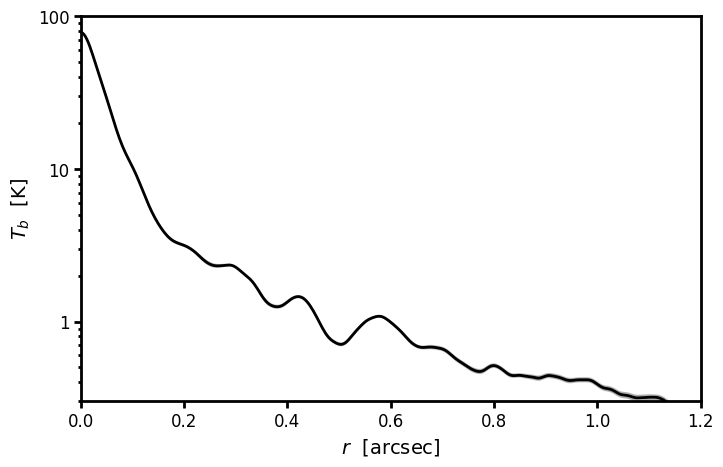

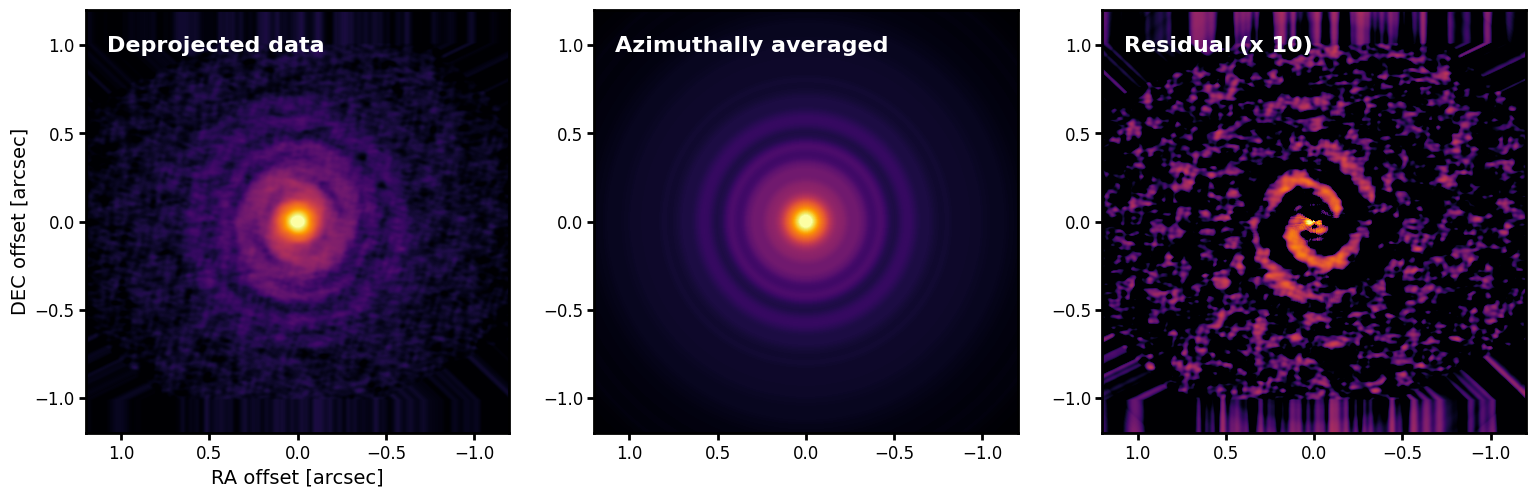

In [19]:
## 4 y 5. Mapa en coordenadas polares y perfil radial

f = interp2d(xdisk, ydisk, deprojected_image, kind='cubic', fill_value=0)

# coordenadas polares
dr = disk_delt
r = np.arange(dr, 2*rout, dr)
theta = np.linspace(-180, 180, 181)
image_polar = np.zeros((theta.size, r.size))

for j in range(theta.size):
    for i in range(r.size):
        # aplicar la transformación inversa para llegar a las coordenadas del disco
        xd = r[i] * np.cos(np.radians(theta[j]))
        yd = r[i] * np.sin(np.radians(theta[j]))
        image_polar[j,i] = f(xd, yd)

# image setups
polar_bounds = (r.min(), r.max(), theta.min(), theta.max())
r_lims = [0, rout]
theta_lims = [theta.min(), theta.max()]

# set up and plot the images on the specified scale
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(image_polar, origin='lower', cmap=cmap, extent=polar_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(theta_lims)
#ax.grid()
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.03)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

fig.savefig('IMLup_polar.pdf')

# plot the radial profile in brightness temperature (R-J limit)
kB_, c_ = 1.38064852e-16, 2.99792e10

# convert radial profile from mJy/beam to brightness temperatures (R-J limit)
Tb = c_**2 * 1e-26 * np.mean(image_polar, axis=0) / beam_area / (2 * kB_ * freq**2)
# error in the mean, assuming the azimuth pixels are independent (which they are probably not, especially at small r)
Tb_err = c_**2 * 1e-26 * np.std(image_polar, axis=0)/np.sqrt(image_polar.shape[0]) / beam_area / (2 * kB_ * freq**2)

fig, ax = plt.subplots(figsize=(8,5))
ax.fill_between(r, Tb-Tb_err, Tb+Tb_err, color='gray', alpha=0.5)
ax.plot(r, Tb, 'k', lw=2, label='Data')
ax.set_xlim([0, rout])
ax.set_ylim([0.3, 100])
ax.set_yscale('log')
ax.set_yticks([1, 10, 100])
ax.set_yticklabels(['1', '10', '100'])
ax.set_xlabel('$r \,\,$ [arcsec]')
ax.set_ylabel('$T_b \,\,$ [K]')
#ax.legend()

# save profile as a plot and ascii text file
fig.savefig('IMLup_radial_profile.pdf')
with open('IMLup_radial_profile.txt', 'w') as f:
    f.write('# r[asec] Tb[K]   Tb_err[K]\n')
    for i in range(r.size):
        f.write(f' {r[i]:6.3f}   {Tb[i]:6.3f} {Tb_err[i]:6.3f}\n')
f.close()

## 7. Creación de imagen axisimétrica a partir del perfil radial e inspección de residuos

# perfil radial que barreremos en torno al centro
SBr = np.mean(image_polar, axis=0)

ny_sweep, nx_sweep = deprojected_image.shape
isweep = np.arange(nx_sweep) - nx_sweep/2
jsweep = np.arange(ny_sweep) - ny_sweep/2
I, J = np.meshgrid(isweep, jsweep)
R = np.sqrt(I**2 + J**2) * dr

image_sweep = np.empty((ny_sweep, nx_sweep))
for k,r1 in enumerate(r):
    ind = ((R >= r1-0.5*dr) & (R < r1+0.5*dr))
    image_sweep[ind] = SBr[k]

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))

# image plot
gs = GridSpec(1,3, hspace=0.2, top=0.97, left=0.07, right=0.97)
fig = plt.figure(figsize=(16,7))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
axes = [ax0, ax1, ax2]

im = ax0.imshow(deprojected_image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imfit = ax1.imshow(image_sweep, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imres = ax2.imshow(10*(deprojected_image-image_sweep), origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)
ax0.set_xlabel('RA offset [arcsec]')
ax0.set_ylabel('DEC offset [arcsec]')
ax0.text(0.05,0.9, 'Deprojected data', color='white', fontsize=16, fontweight='bold', transform=ax0.transAxes)

ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)
ax1.text(0.05,0.9, 'Azimuthally averaged', color='white', fontsize=16, fontweight='bold', transform=ax1.transAxes)

ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)
ax2.text(0.05,0.9, 'Residual (x 10)', color='white', fontsize=16, fontweight='bold', transform=ax2.transAxes)

fig.savefig('IMLup_residual.pdf')

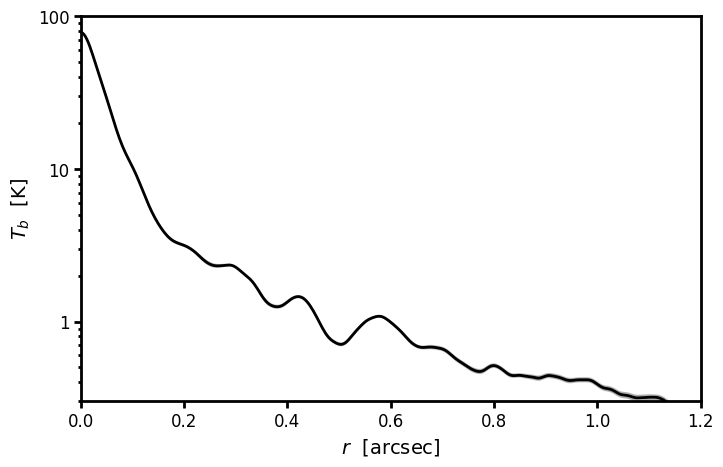

In [12]:
# plot the radial profile in brightness temperature (R-J limit)
kB_, c_ = 1.38064852e-16, 2.99792e10

# convert radial profile from mJy/beam to brightness temperatures (R-J limit)
Tb = c_**2 * 1e-26 * np.mean(image_polar, axis=0) / beam_area / (2 * kB_ * freq**2)
# error in the mean, assuming the azimuth pixels are independent (which they are probably not, especially at small r)
Tb_err = c_**2 * 1e-26 * np.std(image_polar, axis=0)/np.sqrt(image_polar.shape[0]) / beam_area / (2 * kB_ * freq**2)

fig, ax = plt.subplots(figsize=(8,5))
ax.fill_between(r, Tb-Tb_err, Tb+Tb_err, color='gray', alpha=0.5)
ax.plot(r, Tb, 'k', lw=2, label='Data')
ax.set_xlim([0, rout])
ax.set_ylim([0.3, 100])
ax.set_yscale('log')
ax.set_yticks([1, 10, 100])
ax.set_yticklabels(['1', '10', '100'])
ax.set_xlabel('$r \,\,$ [arcsec]')
ax.set_ylabel('$T_b \,\,$ [K]')
#ax.legend()

# save profile as a plot and ascii text file
fig.savefig('IMLup_radial_profile.pdf')
with open('IMLup_radial_profile.txt', 'w') as f:
    f.write('# r[asec] Tb[K]   Tb_err[K]\n')
    for i in range(r.size):
        f.write(f' {r[i]:6.3f}   {Tb[i]:6.3f} {Tb_err[i]:6.3f}\n')
f.close()


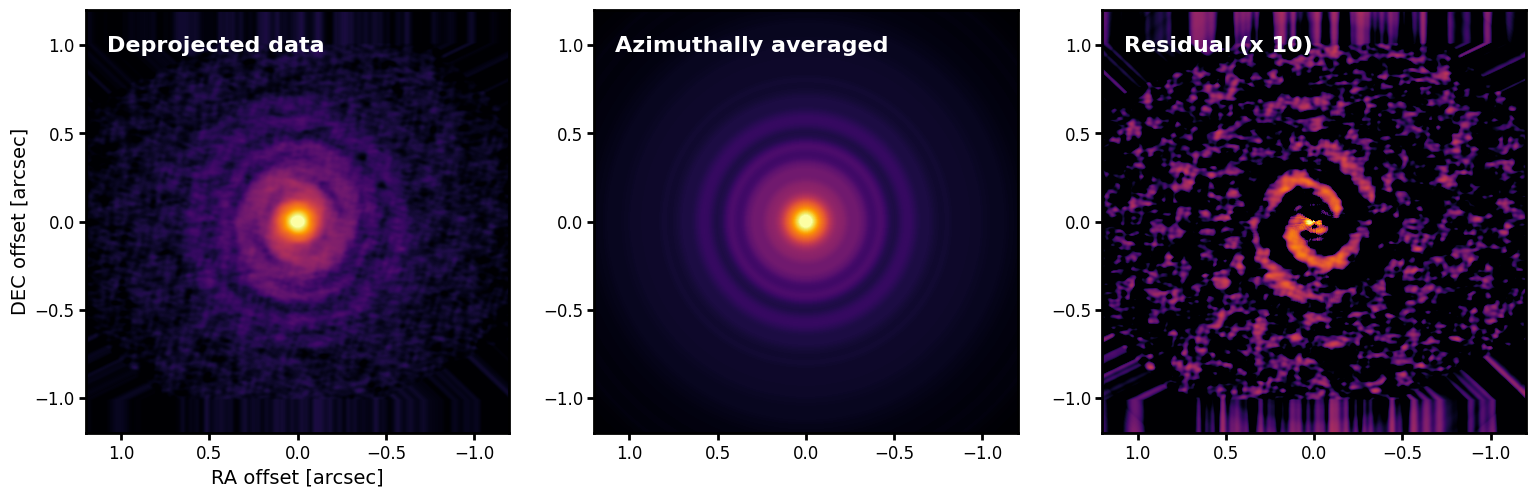

In [13]:
## 7. Creación de imagen axisimétrica a partir del perfil radial e inspección de residuos

# perfil radial que barreremos en torno al centro
SBr = np.mean(image_polar, axis=0)

ny_sweep, nx_sweep = deprojected_image.shape
isweep = np.arange(nx_sweep) - nx_sweep/2
jsweep = np.arange(ny_sweep) - ny_sweep/2
I, J = np.meshgrid(isweep, jsweep)
R = np.sqrt(I**2 + J**2) * dr

image_sweep = np.empty((ny_sweep, nx_sweep))
for k,r1 in enumerate(r):
    ind = ((R >= r1-0.5*dr) & (R < r1+0.5*dr))
    image_sweep[ind] = SBr[k]

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))

# image plot
gs = GridSpec(1,3, hspace=0.2, top=0.97, left=0.07, right=0.97)
fig = plt.figure(figsize=(16,7))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
axes = [ax0, ax1, ax2]

im = ax0.imshow(deprojected_image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imfit = ax1.imshow(image_sweep, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imres = ax2.imshow(10*(deprojected_image-image_sweep), origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)
ax0.set_xlabel('RA offset [arcsec]')
ax0.set_ylabel('DEC offset [arcsec]')
ax0.text(0.05,0.9, 'Deprojected data', color='white', fontsize=16, fontweight='bold', transform=ax0.transAxes)

ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)
ax1.text(0.05,0.9, 'Azimuthally averaged', color='white', fontsize=16, fontweight='bold', transform=ax1.transAxes)

ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)
ax2.text(0.05,0.9, 'Residual (x 10)', color='white', fontsize=16, fontweight='bold', transform=ax2.transAxes)

fig.savefig('IMLup_residual.pdf')


/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_93513/27532930.py:7: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(xsweep, ysweep, image_res, fill_value=0)
/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_93513/27532930.py:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use

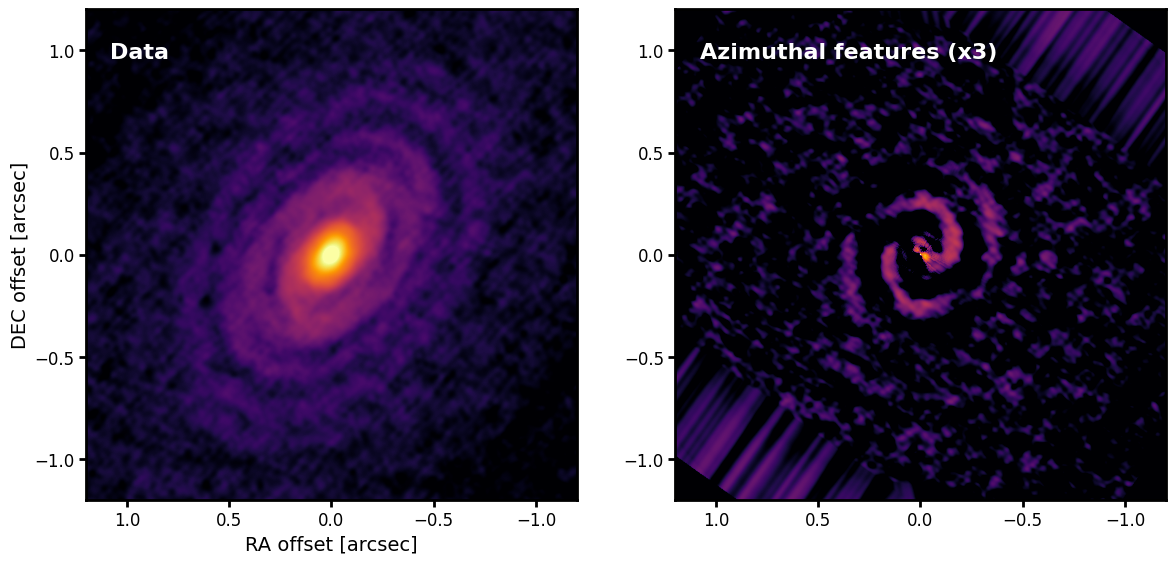

In [14]:
## Bonus: Transformación de vuelta al plano del cielo

image_res = deprojected_image-image_sweep
xsweep = isweep*(-disk_delt)
ysweep = jsweep*disk_delt 
# función para (linealmente) interpolar el mapa
f = interp2d(xsweep, ysweep, image_res, fill_value=0)

image_res_sky = np.zeros(image.shape)

for j in range(ny):
    for i in range(nx):
        # aplicar la transformación inversa para llegar a las coordenadas del cielo
        x = np.cos(PAr)*RAo_shift[i] - np.sin(PAr)*DECo_shift[j]
        y = np.sin(PAr)*RAo_shift[i] + np.cos(PAr)*DECo_shift[j]
        image_res_sky[j,i] = f(x, y)

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))

# image plot
gs = GridSpec(1,2, hspace=0.2, top=0.97, left=0.07, right=0.97)
fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
axes = [ax0, ax1]

im = ax0.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imfit = ax1.imshow(4*image_res_sky, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)
ax0.set_xlabel('RA offset [arcsec]')
ax0.set_ylabel('DEC offset [arcsec]')
ax0.text(0.05,0.9, 'Data', color='white', fontsize=16, fontweight='bold', transform=ax0.transAxes)

ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)
ax1.text(0.05,0.9, 'Azimuthal features (x3)', color='white', fontsize=16, fontweight='bold', transform=ax1.transAxes)

fig.savefig('IMLup_spirals.pdf')